### DSK Projekt "Projekt i implementacja algorytmu wyznaczającego optymalne struktury zgodnej z modelem PMC"

In [1]:
import numpy as np
import networkx as nx
import itertools
from matplotlib import pyplot as plt
from copy import copy
%matplotlib inline

In [2]:
class MinimizerPMC:
    """Graph minimizer for PMC diagnose model"""
        
    def __init__(self, input_path=None, input_matrix=None):
        """
        Constructor loads data from the file and creates networkx digraph instance
        :param input_path: string
        """
        if not input_path == None:
            self.input_matrix = np.loadtxt(input_path)
        else:
            self.input_matrix = input_matrix
        
        self.graph = nx.from_numpy_matrix(self.input_matrix, create_using=nx.DiGraph())
        
    def __check_diagnosability(self, graph, m):
        """
        Private method that checks m-diagnosability according to PMC model
        :param Graph: networkx.classes.digraph.DiGraph
        :param m: int
        :return: boolean
        """
        nodes = list(graph.nodes)
    
        # Checking necessary condition 1
        nes1 = True if len(graph) >= 2 * m + 1 else False 
        
        # Checking necessary condition 2
        nes2 = True
        for node in nodes:
            if graph.in_degree(node) < m:
                nes2 = False

        if nes1 and nes2:
            # Checking Hakimi, Amin conditions
            for s in range(m):
                subsets = list(itertools.combinations(nodes, len(graph) - 2 * m + s))
                for subset in subsets:
                    subset = list(subset)
                    edges = [np.array(list(graph.out_edges(node))).ravel().tolist() for node in subset]
                    merged_edges = list(itertools.chain(*edges))
                    gamma_nodes = list(set([node for node in merged_edges if node not in subset]))
                    if len(gamma_nodes) <= s:
                         return False
            return True

        else:
            return False
        
    def check_diagnosibility(self, m):
        """
        Checks diagnosability of input graph for given m
        :param m: int
        :return: boolean
        """
        return self.__check_diagnosability(self.graph, m)
    
    def minimize(self, m):
        """
        Minimizes graph to its minimal m-diagnosable (according to PMC model) form.
        Returns minimal form or initial form if initial graph is not m-diagnosable.
        :param m: int
        :return: numpy.ndarray
        """
        if not self.__check_diagnosability(self.graph, m):
            print(f"Graph is not {m}-diagnosable so it cannot be minimized")
            return self.input_matrix
        
        # Preparing non protected nodes - nodes with in_degree greater than m,
        # which can be reduced up to in_degree = m (Necessary condition 2)
        non_protected_nodes = list(range(len(self.input_matrix)))
        for node_number, row in enumerate(np.transpose(self.input_matrix)):
            if np.count_nonzero(row==1) == m:
                non_protected_nodes.remove(node_number)
                
        minimized_matrix = copy(self.input_matrix)
        
        # Minimizing - removing in edges for non protected nodes
        for node_number in non_protected_nodes:
            for edge_number in range(len(minimized_matrix)):
                if minimized_matrix[:, node_number][edge_number] == 1.0:
                    minimized_matrix[:, node_number][edge_number] = 0
                    if not self.__check_diagnosability(nx.from_numpy_matrix(
                        minimized_matrix, create_using=nx.DiGraph()), m):
                        minimized_matrix[:, node_number][edge_number] = 1.0
                    else:
                        # If edge was succesfully removed, checks necessary 
                        # condition 2 before trying to remove further edges.
                        row = np.transpose(minimized_matrix)[node_number]
                        if np.count_nonzero(row==1) == m:
                            break
                
        return minimized_matrix
        
        
        
    
    def show_graph(self):
        """
        Displays graph with matplotlib library
        """
        graph_fixed_pos = nx.spring_layout(self.graph, seed=100)
        nx.draw(self.graph, pos=graph_fixed_pos, with_labels=True)
        plt.show()
        
    
    
    

## Sprawdzenie diagnozowalności

### Struktura rzędu 5, jest 2-diagnozowalna

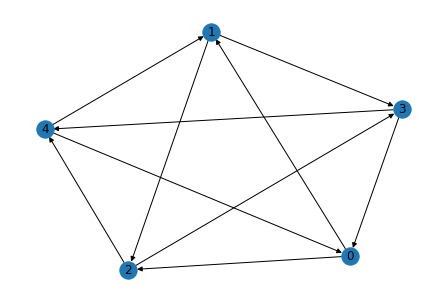

True

In [3]:
c = MinimizerPMC('Inputs/input_struct2.txt')
c.show_graph()
c.check_diagnosibility(2)

### Struktura rzędu 5, nie jest 2-diagnozowalna

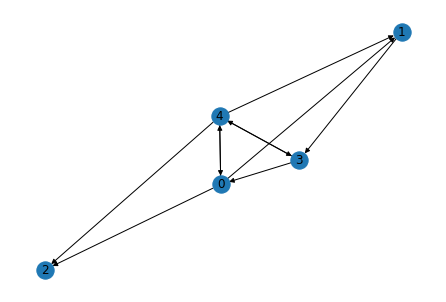

False

In [4]:
c = MinimizerPMC('Inputs/input_struct3.txt')
c.show_graph()
c.check_diagnosibility(2)

### Struktura rzędu 9, jest 4-diagnozowalna

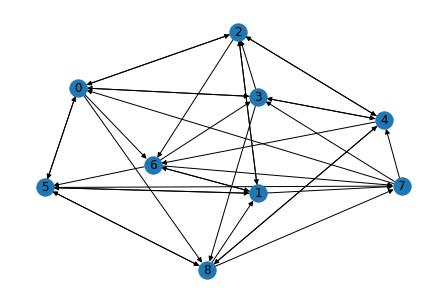

True

In [5]:
c = MinimizerPMC('Inputs/input_struct4.txt')
c.show_graph()
c.check_diagnosibility(4)

### Struktura rzędu 15, jest 5-diagnozowalna

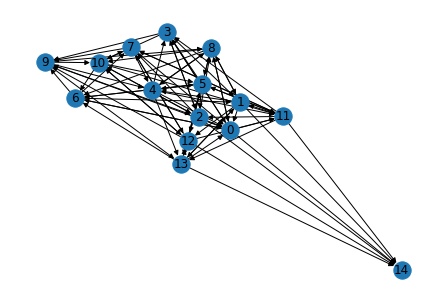

True

In [6]:
c = MinimizerPMC('Inputs/input_struct_large.txt')
c.show_graph()
c.check_diagnosibility(5)

## Sprawdzenie minimalizacji

### Struktura rzędu 5, minimalizacja dla 2-diagnozowalnej

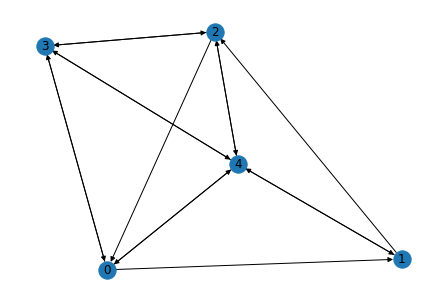

Po minimalizacji:

[[0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0.]]


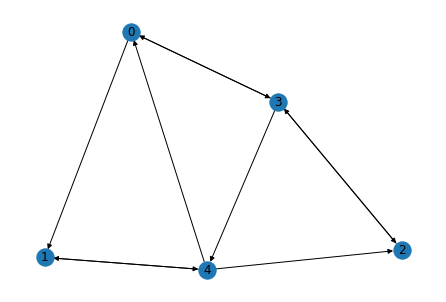

In [7]:
g = MinimizerPMC('Inputs/input_struct_to_minimize.txt')
g.show_graph()
print("Po minimalizacji:")
print()
minimized = g.minimize(2)
print(minimized)
minimized = MinimizerPMC(input_matrix=minimized)
minimized.show_graph()

### Struktura rzędu 15, minimalizacja dla 5-diagnozowalnej

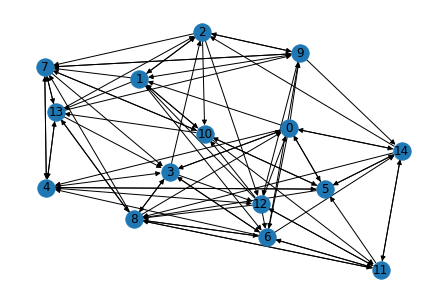

Po minimalizacji:

[[0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]]


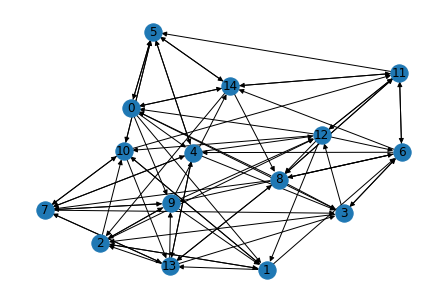

In [8]:
g = MinimizerPMC('Inputs/input_struct_to_minimize_large.txt')
g.show_graph()
print("Po minimalizacji:")
print()
minimized = g.minimize(5)
print(minimized)
minimized = MinimizerPMC(input_matrix=minimized)
minimized.show_graph()

### Pełna struktura rzędu 9, minimalizacja dla 4-diagnozowalnej

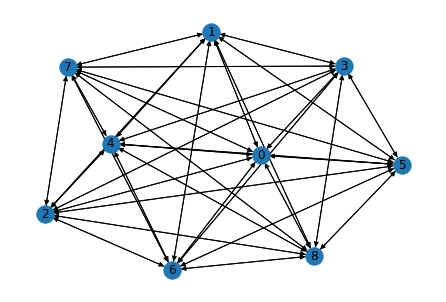

Po minimalizacji:

[[0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0.]]


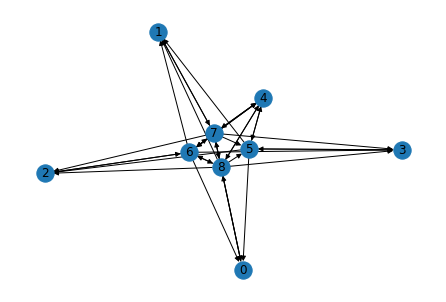

In [9]:
g = MinimizerPMC('Inputs/input_struct_to_minimize_large2.txt')
g.show_graph()
print("Po minimalizacji:")
print()
minimized = g.minimize(4)
print(minimized)
minimized = MinimizerPMC(input_matrix=minimized)
minimized.show_graph()

### Pełna struktura rzędu 12, minimalizacja dla 5-diagnozowalnej (Uwaga na długi czas wykonywania!)

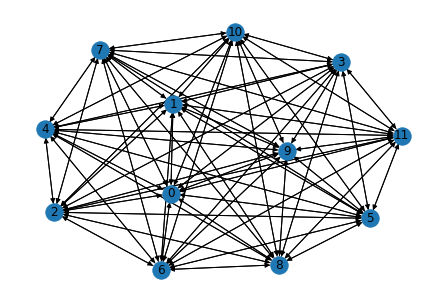

Po minimalizacji:

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]


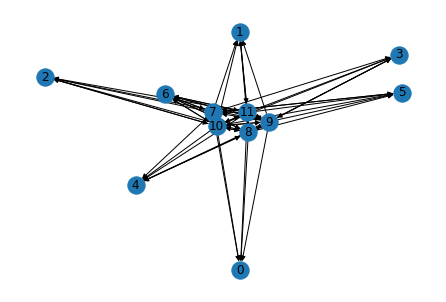

In [10]:
g = MinimizerPMC('Inputs/input_struct_to_minimize_large3.txt')
g.show_graph()
print("Po minimalizacji:")
print()
minimized = g.minimize(5)
print(minimized)
minimized = MinimizerPMC(input_matrix=minimized)
minimized.show_graph()